In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

# processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

# model
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import norm, skew

warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^.*LAPACK bug 0038.*")

In [2]:
# load training data split train_x and train_y
train_pd = pd.read_csv("all/train.csv")
train_x = train_pd.drop(['SalePrice'], axis=1)
train_y = train_pd['SalePrice']

test_pd = pd.read_csv("all/test.csv")
print(train_x.shape)
print(train_y.shape)
print(test_pd.shape)

(1460, 80)
(1460,)
(1459, 80)


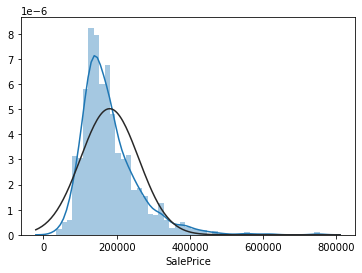

In [3]:
# saleprice distribution
sns.distplot(train_pd['SalePrice'], fit = norm);

# Data is right skewed

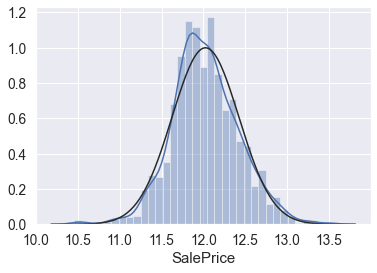

In [20]:
sns.distplot(np.log1p(train_pd['SalePrice']), fit = norm);


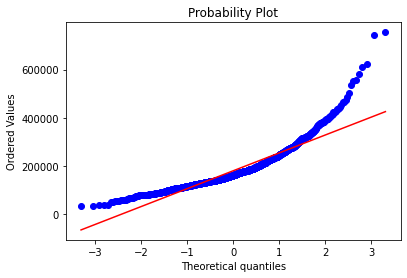

In [4]:
# qq-plot
fig = plt.figure()
res = stats.probplot(train_pd['SalePrice'], plot=plt)
plt.show()

# Also show that is right skewed

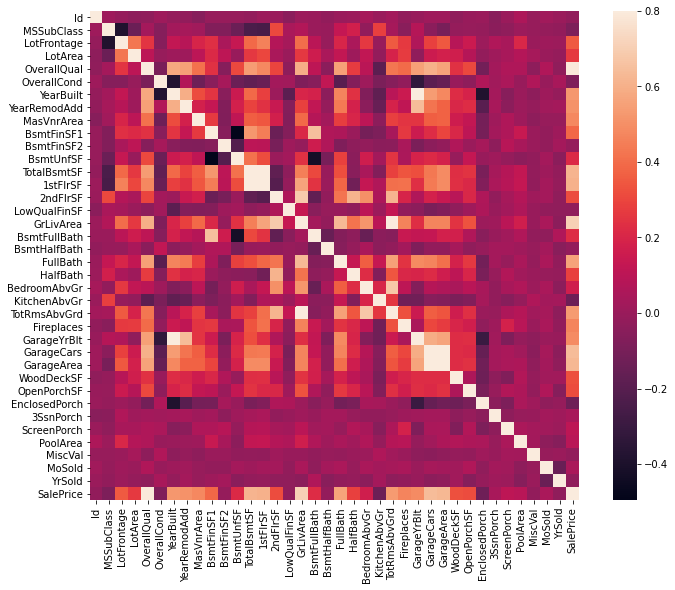

In [5]:
#correlation matrix
corrmat = train_pd.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

['SalePrice' 'OverallQual' 'GrLivArea' 'GarageCars' 'GarageArea'
 'TotalBsmtSF' '1stFlrSF' 'FullBath' 'TotRmsAbvGrd' 'YearBuilt']


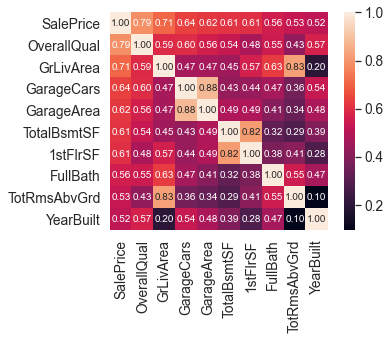

In [6]:
# select top 10 corr to saleprice
top_10 = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
print(top_10.values)
cm = np.corrcoef(train_pd[top_10].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=top_10.values, xticklabels=top_10.values)
plt.show()

# some values are correlated with each other

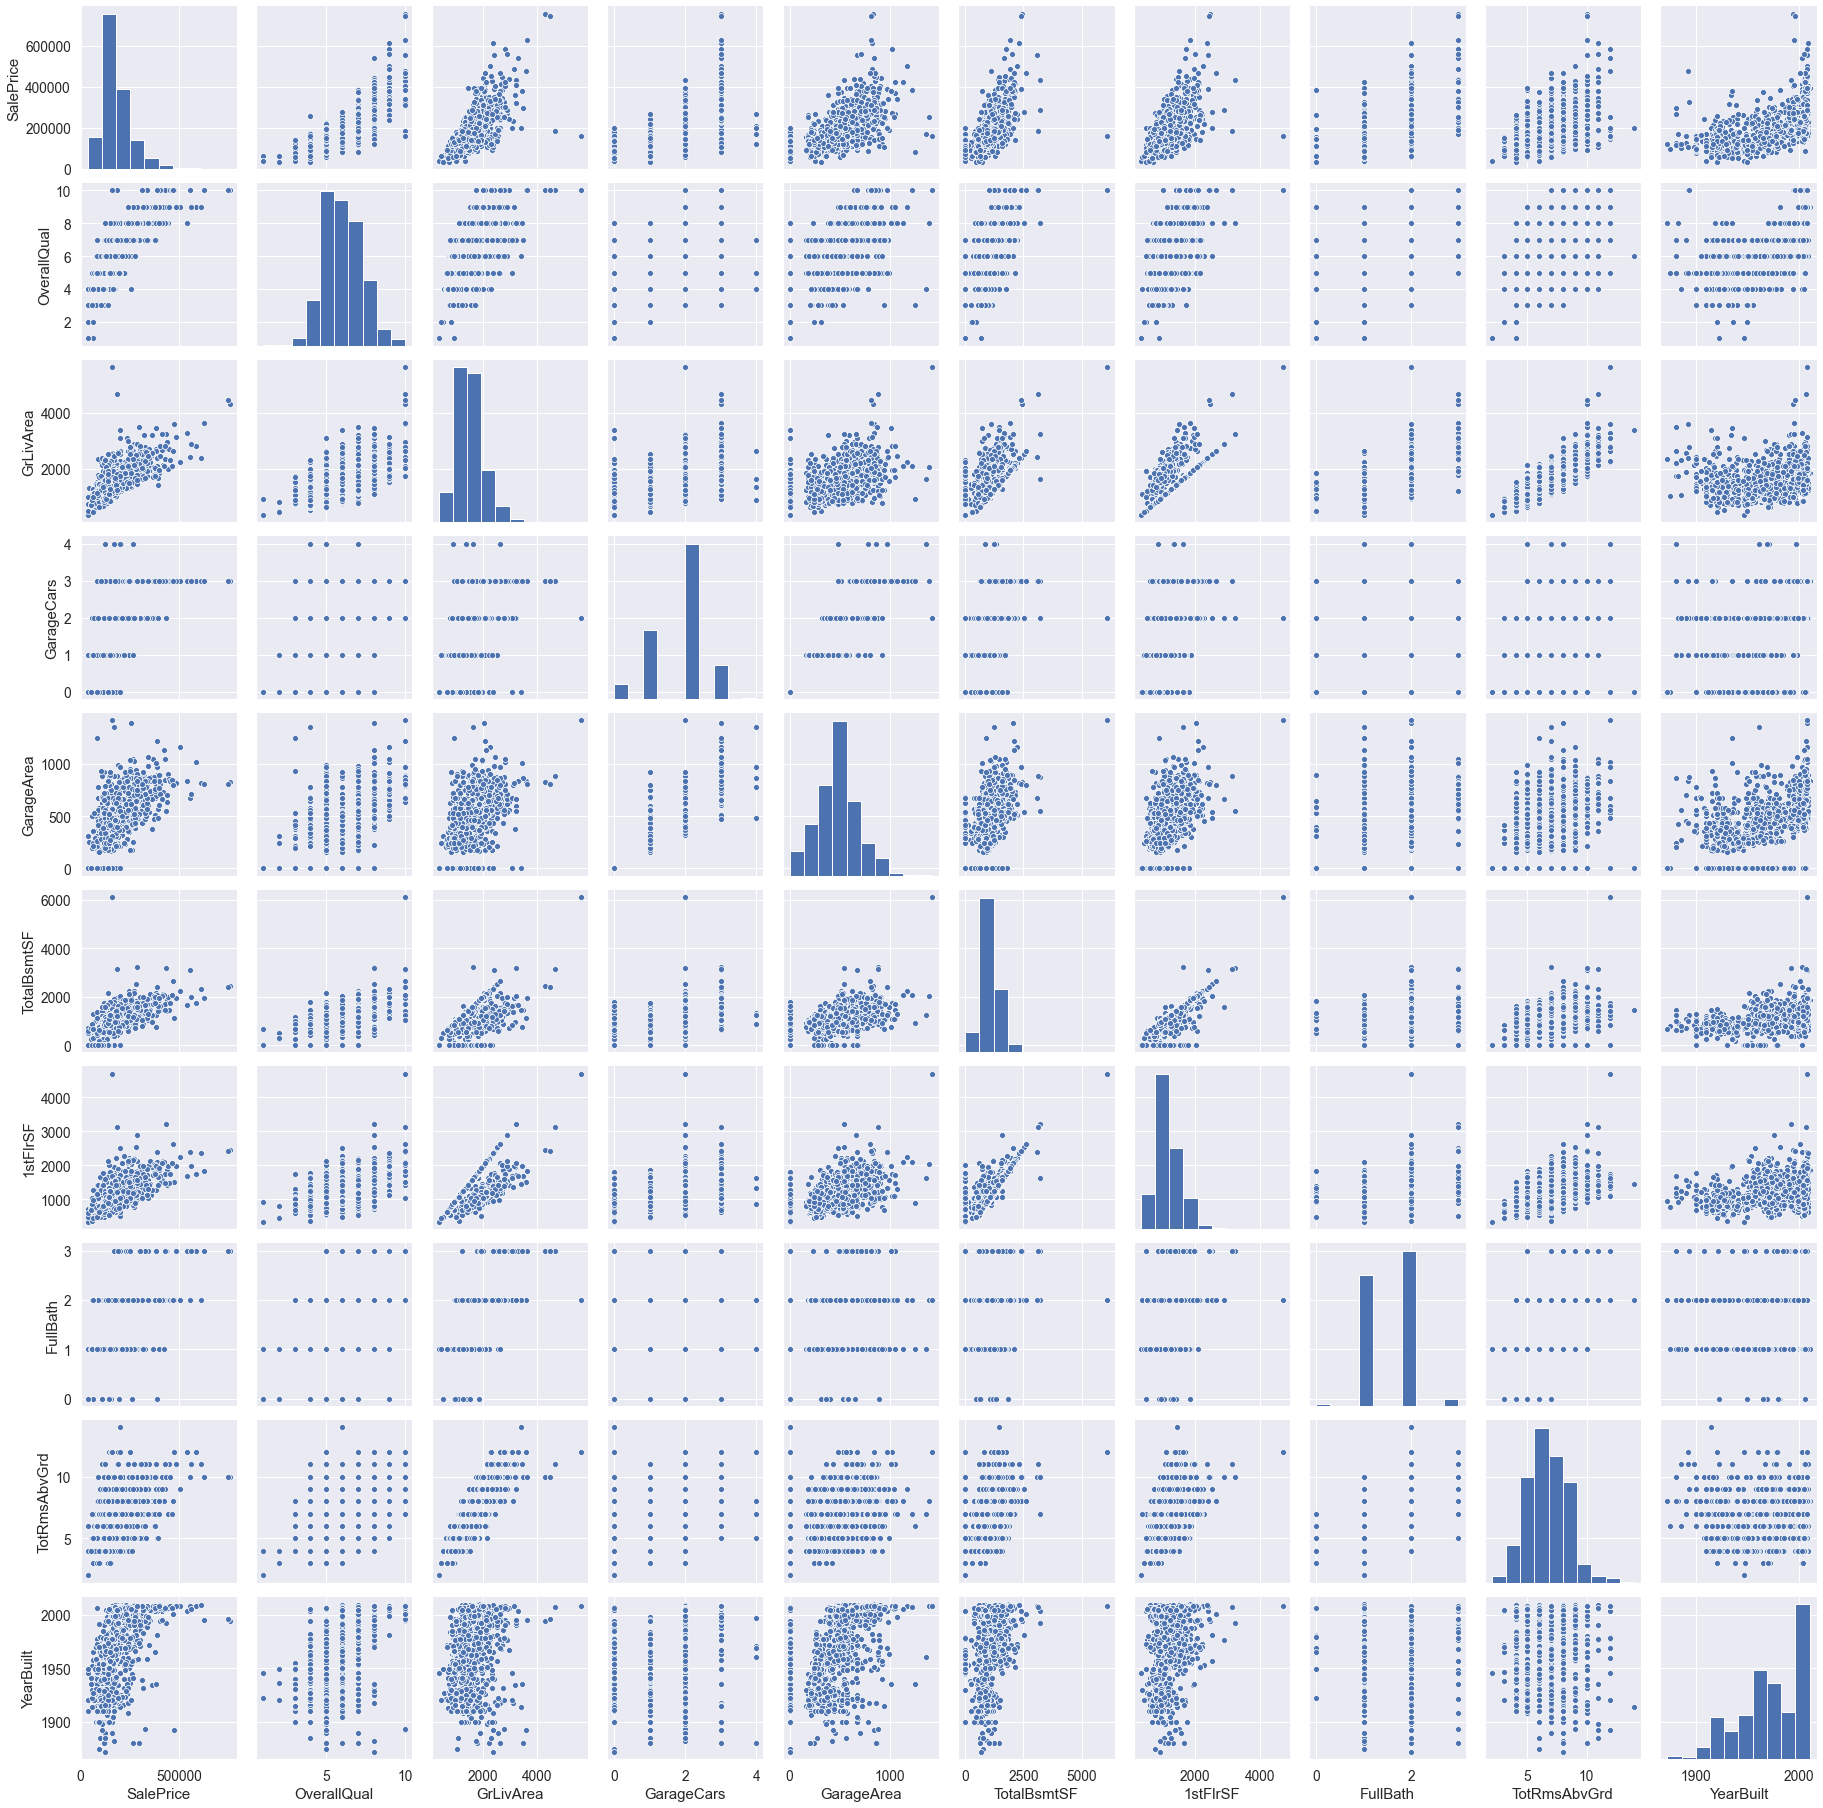

In [7]:
# pair plot top 10 features
sns.pairplot(train_pd[top_10.values])

# first row shows sale price with other 9 features plot, there are some outliers

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


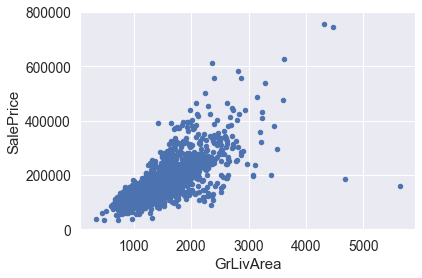

In [8]:
# GrLive Area
data = pd.concat([train_pd['SalePrice'], train_pd['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

# some house have low price with large area which is not make sense

In [11]:
# load training data split train_x and train_y
train_pd = pd.read_csv("all/train.csv")

# remove outlier from data analysis
# drop outliers
query = train_pd[(train_pd['GrLivArea'] > 4000) & (train_pd['SalePrice'] < 200000)]
train_pd = train_pd.drop(query.index.values)

train_x = train_pd.drop(['SalePrice'], axis=1)
train_x['is_train'] = 1
train_y = train_pd['SalePrice']

test_pd = pd.read_csv("all/test.csv")
test_pd['is_train'] = 0
print(train_x.shape)
print(train_y.shape)
print(test_pd.shape)
all_data = pd.concat((train_x, test_pd)).reset_index(drop=True)
print(all_data.shape)
all_data = all_data.drop(['Id'], axis=1)
print(all_data.shape)

(1458, 81)
(1458,)
(1459, 81)
(2917, 81)
(2917, 80)


In [12]:
# split features into object_columns and numerical_columns
object_columns_df = all_data.select_dtypes(include=['object'])
numerical_columns_df = all_data.select_dtypes(exclude=['object'])

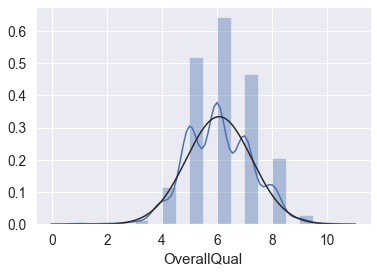

In [13]:
LF_NAN = numerical_columns_df[numerical_columns_df['LotFrontage'].isna()]
# print(LF_NAN)
sns.distplot(LF_NAN['OverallQual'], fit = norm);

# since the price is highly corr to overallQual, we can estimate that LotFrontage has normal distribution
# on the missing data. Therefore we can fit data with average LotFrontage

5.229514140681653


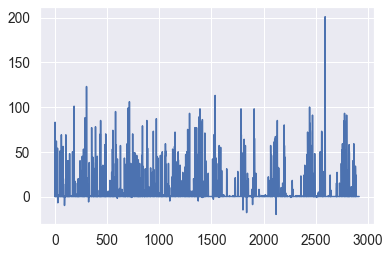

In [18]:
# GarageYrBlt
blts_not_nan = all_data[all_data['GarageYrBlt'].notna()]
blts = blts_not_nan[['GarageYrBlt', 'YearBuilt']]
blt_diff = blts['GarageYrBlt'] - blts['YearBuilt']
blt_diff.plot()
# garage year built sometimes is later than year built. and some garage built before house.

print(blt_diff.mean())
# garage built is later than house 5 years, which is reasonable. But we should consider the outliers of one sample,
# which has 200 more years difference. Therefore, I fill with 3-4 years maybe reasonable

In [19]:
print(train_pd.shape)

(1458, 81)


In [4]:
tmp = pd.read_pickle("tmp")

   MSSubClass MSZoning  LotFrontage  LotArea Street  LotShape LandContour  \
0          60       RL         65.0     8450   Pave         3         Lvl   
1          20       RL         80.0     9600   Pave         3         Lvl   
2          60       RL         68.0    11250   Pave         2         Lvl   
3          70       RL         60.0     9550   Pave         2         Lvl   
4          60       RL         84.0    14260   Pave         2         Lvl   

  Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0    AllPub    Inside       Gtl  ...             0         0           0   
1    AllPub       FR2       Gtl  ...             0         0           0   
2    AllPub    Inside       Gtl  ...             0         0           0   
3    AllPub    Corner       Gtl  ...           272         0           0   
4    AllPub       FR2       Gtl  ...             0         0           0   

  PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition is_train  
0        

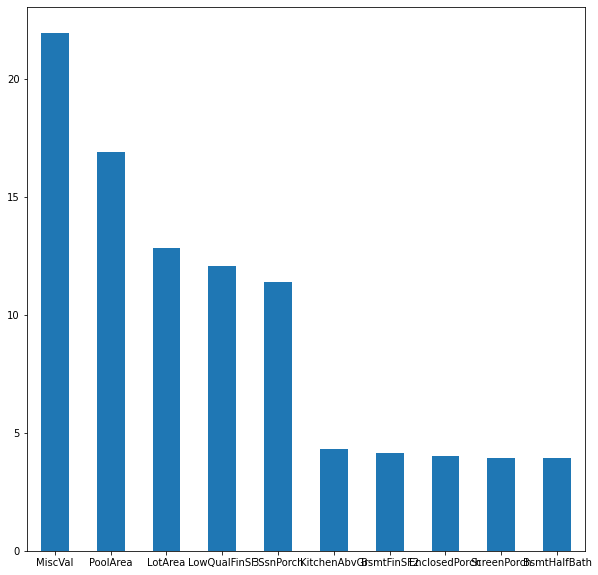

In [15]:
skewValue = tmp.skew().sort_values(ascending=False)
large_skew = skewValue[abs(skewValue) > 0.75]
large_skew.head(10).plot.bar(x=large_skew.index, y=large_skew.values, rot=0, figsize=(10,10))

# some skewness is large